<a href="https://colab.research.google.com/github/jaisal1024/advanced-investments-final/blob/master/AI_final_regressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Investments Finals
## Jaisal Friedman 
### May 8, 2018

#### Feature & Methodology
*Call/Put Monthly Option Volume* on
1.  Predictive Regression
2. Fama-French
3. Fama-Macbeth

In [0]:
#%matplotlib inline
import sys
import os
import statistics as stat
import matplotlib.pyplot as plt
plt.close('all')
import pandas as pd
import numpy as np
import sklearn
import datetime
from datetime import datetime, timedelta
from sklearn import linear_model
import statsmodels.api as sm
from google.colab import files

In [0]:
# import cleaned data from github
url_crsp = 'https://raw.githubusercontent.com/jaisal1024/advanced-investments-final/master/data/crsp_merged-81-ret-beta.csv'
url_fama = 'https://raw.githubusercontent.com/jaisal1024/advanced-investments-final/master/data/fama-french-indices.csv'
df_crsp = pd.read_csv(url_crsp)
df_fama = pd.read_csv(url_fama)

## Predictive Regression
1. Build a predictive return function
2. Add rff rate to fama set

In [0]:
def predictive_regression(df_, months_shift): 
  df = df_.copy()
  char_ = "ratio_vol_-"+str(months_shift)
  df[char_] = df['ratio_vol'].shift(-1)
  df_pred = df.groupby('date').mean()
  df_pred = df_pred.drop(['DLPRC', 'DLRET'], axis=1)
  df_pred = df_pred.iloc[:-months_shift]
  df_pred.replace([np.inf, -np.inf], np.nan)
  df_pred.dropna(subset=['RET-RF', char_], how = 'any',axis='index', inplace=True)
  X = list(df_pred[char_])
  Y = list(df_pred['RET-RF'])
  model = sm.OLS(Y, X).fit()
  P = X*model.params
  print("DEV of Model Pred /MEAN of RET-RF: ", stat.stdev(P)/stat.mean(Y))
  return model

In [93]:
model_1_mth = predictive_regression(df_crsp, 1)
model_3_mth = predictive_regression(df_crsp, 3)
model_6_mth = predictive_regression(df_crsp, 6)
model_12_mth = predictive_regression(df_crsp, 12)

DEV of Model Pred /MEAN of RET-RF:  0.38787751578180674
DEV of Model Pred /MEAN of RET-RF:  0.3896425575256668
DEV of Model Pred /MEAN of RET-RF:  0.39380720890451093
DEV of Model Pred /MEAN of RET-RF:  0.3626400118613368


In [328]:
#@title Predictive Regression 1-month Lag on Call/Put Ratio {display-mode: "form"}
print(model_1_mth.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     7.463
Date:                Wed, 08 May 2019   Prob (F-statistic):            0.00727
Time:                        19:53:50   Log-Likelihood:                 182.10
No. Observations:                 119   AIC:                            -362.2
Df Residuals:                     118   BIC:                            -359.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0067      0.002      2.732      0.0

In [329]:
#@title Predictive Regression 3-month Lag on Call/Put Ratio {display-mode: "form"}
print(model_3_mth.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     7.253
Date:                Wed, 08 May 2019   Prob (F-statistic):            0.00813
Time:                        19:53:57   Log-Likelihood:                 178.06
No. Observations:                 117   AIC:                            -354.1
Df Residuals:                     116   BIC:                            -351.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0067      0.002      2.693      0.0

In [330]:
#@title Predictive Regression 6-month Lag on Call/Put Ratio {display-mode: "form"}
print(model_6_mth.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     7.060
Date:                Wed, 08 May 2019   Prob (F-statistic):            0.00902
Time:                        19:54:10   Log-Likelihood:                 173.46
No. Observations:                 114   AIC:                            -344.9
Df Residuals:                     113   BIC:                            -342.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0066      0.002      2.657      0.0

In [331]:
#@title Predictive Regression 1-year Lag on Call/Put Ratio {display-mode: "form"}
print(model_12_mth.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     7.119
Date:                Wed, 08 May 2019   Prob (F-statistic):            0.00881
Time:                        19:54:14   Log-Likelihood:                 163.37
No. Observations:                 108   AIC:                            -324.7
Df Residuals:                     107   BIC:                            -322.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0068      0.003      2.668      0.0

# Fama-French
1. Sort based into 8 portfolios based on call/put ratio vol at start of each year June
2. Calculate return of each portfolio for the year
3. Re-shuffle portfolios
4. Repeat until 10 years has past

In [0]:
start_years = ['200607','200707','200807','200907','201007','201107','201207','201307', '201407', '201507','201607']
df_avg_ret_top = pd.DataFrame(columns=['date', 'RET-RF'])
df_avg_ret_bottom = pd.DataFrame(columns=['date', 'RET-RF'])
df = df_crsp.copy()
df['datetime'] = df['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))

In [0]:
for i, j in zip(start_years, start_years[1:]):
  #select only data in this year
  start_date = datetime.strptime(i+'01','%Y%m%d')
  end_date = datetime.strptime(j+'01','%Y%m%d')
  mask_date = (df['datetime'] > start_date) & (df['datetime'] <= end_date)
  df_to_sort = df[mask_date]

  #########################
  #below is the top 20:
  ########################
  df_year_top = df[mask_date]
  df_sorted_top = df_to_sort.sort_values(by=['ratio_vol'], ascending=False).head(20)
  company_top = list(df_sorted_top['ticker'])
  mask_comp_top = df['ticker'].isin(company_top)
  df_year_top = df_year_top.loc[mask_comp_top] 
  df_avg_ret_top = df_avg_ret_top.append(df_year_top[['date','RET-RF']])

  #########################
  #below is the bottom 20:
  ########################
  df_year_bottom = df[mask_date]
  df_sorted_bottom = df_to_sort.sort_values(by=['ratio_vol'], ascending=False).tail(20)
  df_year_bottom = df.loc[mask_date]
  company_bottom = list(df_sorted_bottom['ticker'])
  mask_comp_bottom = df['ticker'].isin(company_bottom)
  df_year_bottom = df_year_bottom.loc[mask_comp_bottom]
  df_avg_ret_bottom = df_avg_ret_bottom.append(df_year_bottom[['date','RET-RF']])

In [0]:
df_avg_ret_top__ = df_avg_ret_top.groupby('date').mean()
df_avg_ret_bottom__ = df_avg_ret_bottom.groupby('date').mean()

In [0]:
# merge with fama_french 
df_fama = df_fama.rename(index = str, columns = {'dateff': 'date'})
#merging top:
df_fama_bottom = pd.merge(df_avg_ret_bottom__, df_fama, on='date', how='left')
#merging bottom:
df_fama_top = pd.merge(df_avg_ret_top__, df_fama, on='date', how='left')

In [339]:
#@title Fama French 1-Factor Top Regression {display-mode: "form"}
X_top_1 = df_fama_top[['mktrf']]
Y_top_1 = df_fama_top['RET-RF']

X_top_1_ = sm.add_constant(X_top_1)
model_top_1 = sm.OLS(Y_top_1, X_top_1_).fit()
print(model_top_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 RET-RF   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     227.0
Date:                Wed, 08 May 2019   Prob (F-statistic):           2.93e-29
Time:                        19:55:16   Log-Likelihood:                 244.26
No. Observations:                 120   AIC:                            -484.5
Df Residuals:                     118   BIC:                            -478.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.003      1.359      0.1

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [340]:
#@title Fama French 1-Factor Top Regression {display-mode: "form"}
X_bot_1 = df_fama_bottom[['mktrf']]
Y_bot_1 = df_fama_bottom['RET-RF']

X_bot_1_ = sm.add_constant(X_bot_1)
model_bot_1 = sm.OLS(Y_bot_1, X_bot_1_).fit()
print(model_bot_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 RET-RF   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     312.0
Date:                Wed, 08 May 2019   Prob (F-statistic):           6.33e-35
Time:                        19:55:20   Log-Likelihood:                 207.90
No. Observations:                 120   AIC:                            -411.8
Df Residuals:                     118   BIC:                            -406.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0038      0.004     -0.950      0.3

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [341]:
#@title Fama French 3-Factor Top Regression {display-mode: "form"}
X_top = df_fama_top[['mktrf','smb','hml']]
Y_top = df_fama_top['RET-RF']

X_top_ = sm.add_constant(X_top)
model_top = sm.OLS(Y_top, X_top_).fit()
print(model_top.summary())

                            OLS Regression Results                            
Dep. Variable:                 RET-RF   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     76.77
Date:                Wed, 08 May 2019   Prob (F-statistic):           1.99e-27
Time:                        19:55:23   Log-Likelihood:                 245.52
No. Observations:                 120   AIC:                            -483.0
Df Residuals:                     116   BIC:                            -471.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.003      1.490      0.1

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [342]:
#@title Fama French 3-Factor Bottom Regression {display-mode: "form"}
X_bottom = df_fama_bottom[['mktrf','smb','hml']]
Y_bottom = df_fama_bottom['RET-RF']

X_bottom_ = sm.add_constant(X_bottom)
model_bottom = sm.OLS(Y_bottom, X_bottom_).fit()
print(model_bottom.summary())

                            OLS Regression Results                            
Dep. Variable:                 RET-RF   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     124.6
Date:                Wed, 08 May 2019   Prob (F-statistic):           3.98e-36
Time:                        19:55:27   Log-Likelihood:                 216.73
No. Observations:                 120   AIC:                            -425.5
Df Residuals:                     116   BIC:                            -414.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.004     -0.475      0.6

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [343]:
#@title Fama French 1-Factor Long-Short Regression {display-mode: "form"}
X_LS_1 = df_fama_top[['mktrf']]
Y_LS_1 = df_fama_top['RET-RF'] - df_fama_bottom['RET-RF']

X_LS_1_ = sm.add_constant(X_LS_1)
model_LS_1 = sm.OLS(Y_LS_1, X_LS_1_).fit()
print(model_LS_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 RET-RF   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     44.75
Date:                Wed, 08 May 2019   Prob (F-statistic):           7.91e-10
Time:                        19:55:30   Log-Likelihood:                 210.68
No. Observations:                 120   AIC:                            -417.4
Df Residuals:                     118   BIC:                            -411.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.004      1.999      0.0

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [344]:
#@title Fama French 3-Factor Long-Short Regression {display-mode: "form"}
X_LS_3 = df_fama_top[['mktrf','smb','hml']]
Y_LS_3 = df_fama_top['RET-RF'] - df_fama_bottom['RET-RF']

X_LS_3_ = sm.add_constant(X_LS_3)
model_LS_3 = sm.OLS(Y_LS_3, X_LS_3_).fit()
print(model_LS_3.summary())

                            OLS Regression Results                            
Dep. Variable:                 RET-RF   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     20.70
Date:                Wed, 08 May 2019   Prob (F-statistic):           8.26e-11
Time:                        19:55:33   Log-Likelihood:                 217.11
No. Observations:                 120   AIC:                            -426.2
Df Residuals:                     116   BIC:                            -415.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.004      1.652      0.1

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [0]:
df_fama_top = df_fama_top.rename(index = str, columns = {'RET-RF':'TOP-REF-RF'})
df_fama_bottom = df_fama_bottom.rename(index = str, columns = {'RET-RF':'BOTTOM-REF-RF'})
df_cum = df_fama_top[['date', 'TOP-REF-RF']]
df_cum = df_cum.merge(df_fama_bottom[['date', 'BOTTOM-REF-RF', 'mktrf']], on = 'date', how = 'inner')
df_cum.set_index('date', inplace=True)

In [0]:
df_cum.reset_index(inplace=True)
df_cum['datetime'] = df_cum['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
df_cum.set_index('datetime',inplace=True)
df_cum.drop(['level_0', 'index','date'],axis = 1, inplace=True)

In [0]:
df_cum['LONG_SHORT_RET-RF'] = df_cum['TOP-REF-RF'] - df_cum['BOTTOM-REF-RF']

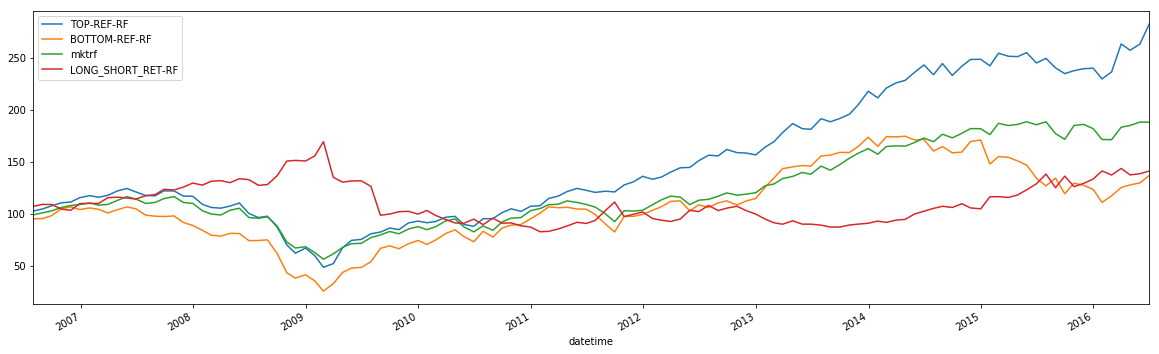

In [327]:
#@title Fama French Cumulative Returns on $100 Portfolio {display-mode: "form"}
df_cumret = (df_cum+1).cumprod()*100
df_cumret.plot(figsize= (20,6));

# Fama-Macbeth
1. For each company run a regression on market returns to calculate Beta
2. Calculate lambda1 and lambda2 based on beta and indicator to predict returns-risk free rate

In [0]:
def calc_beta(df_ ,df_fama_mkt, ticker, betas):
  df = pd.merge(df_.loc[df_['ticker'] == ticker, ['date','RET-RF', 'ratio_vol']], df_fama_mkt, on='date', how = 'left')
  X = list(df['mktrf'])
  Y = list(df['RET-RF'])
  beta = sm.OLS(Y, X).fit().params[0]
  betas[ticker] = beta

In [0]:
df_fama_mkt = df_fama.copy()
df_fama_mkt.rename(index = str, columns = {'dateff': 'date'}, inplace = True)
df_fama_mkt.drop(['smb', 'hml', 'rf', 'umd'], axis = 1, inplace=True)

tickers = df_crsp.ticker.unique()
betas = {}
for ticker in tickers: 
  calc_beta(df_crsp, df_fama_mkt, ticker, betas)

In [0]:
df_betas = pd.DataFrame.from_dict(betas, orient = 'index', columns = ['Beta'])
df_crsp['beta'] = df_crsp['ticker'].apply(lambda x: betas[x])

In [0]:
def fama_mac(df_, date_, fama_):
  X = df_[['beta', 'ratio_vol']]
  Y = list(df_['RET-RF'])
  X_= sm.add_constant(X, has_constant='add')
  fama_mg = sm.OLS(Y, X_).fit()
  fama_[date_] = [fama_mg.params[0], fama_mg.params[1], fama_mg.params[2]]
  return 

In [0]:
unique_dates = list(df_crsp.date.unique())
fama = {}
for date in unique_dates: 
  fama_mac(df_crsp.loc[df_crsp['date'] == date], date, fama)

In [0]:
df_fama_mac = pd.DataFrame.from_dict(fama, orient = 'index', columns = ['alpha', 'lambda1', 'lambda2'])
df_fama_mac.head()

In [199]:
print("Beta Lambda1 Mean:", df_fama_mac.lambda1.mean(), "\nBeta Lambda1 StDev:",df_fama_mac.lambda1.std(), "\nt-test:", abs(df_fama_mac.lambda1.mean()/df_fama_mac.lambda1.std()))
print("\nRatio Options Vol Lambda2 Mean:", df_fama_mac.lambda2.mean(), "\nRatio Options Vol Lambda2 StDev:",df_fama_mac.lambda2.std(), "\nt-test:", abs(df_fama_mac.lambda2.mean()/df_fama_mac.lambda2.std()))
print("\nAlpha Mean:", df_fama_mac.alpha.mean(), "\nAlpha StDev:",df_fama_mac.alpha.std(),"\nt-test:",  abs(df_fama_mac.alpha.mean()/df_fama_mac.alpha.std()))

Beta Lambda1 Mean: -0.001266767180708773 
Beta Lambda1 StDev: 0.06199728844749373 
t-test: 0.020432622336081906

Ratio Options Vol Lambda2 Mean: 0.005149882142597017 
Ratio Options Vol Lambda2 StDev: 0.010540703111255456 
t-test: 0.4885710268319698

Alpha Mean: 0.0007247960185920543 
Alpha StDev: 0.043300658403403504 
t-test: 0.016738683551635884
